In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount("./drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [2]:
!ls "./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints"

GRU_1layer.hdf5  GRU_3layer.hdf5  LSTM_2layer.hdf5  LSTM_5layer.hdf5
GRU_2layer.hdf5  GRU_5layer.hdf5  LSTM_3layer.hdf5


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from matplotlib import pyplot as plt

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# reading raw data
df = pd.read_csv('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/Iran.Khodro.csv.txt', parse_dates=['<DTYYYYMMDD>'])
close_values = df['<CLOSE>'].to_numpy()

# reshaping close_values
close_values = np.reshape(close_values, (-1, 1))

# scaling the close_values into (0, 1)
sc = MinMaxScaler(feature_range=(-1, 1))
close_values = sc.fit_transform(close_values)

# fliping close_values to be in the right order of time from past to future
close_values = np.flipud(close_values)

# applying short-term memory filter of time-lag P and future Q to close_values
P = 180
Q = 30
memory_response = series_to_supervised(close_values, n_in=P, n_out=Q)
# print(memory_response)
memory_response = memory_response.to_numpy()

# memory_response = np.reshape(memory_response, (-1, P, 1))


# constructing training and test sets
x_train = memory_response[:-30, :-Q]
y_train = memory_response[:-30, -Q:]


x_test = memory_response[-30:, :-Q]
y_test = memory_response[-30:, -Q:]


x_train = np.reshape(x_train, (-1, P, 1))
x_test = np.reshape(x_test, (-1, P, 1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3535, 180, 1) (3535, 30)
(30, 180, 1) (30, 30)


In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/GRU_5layer.hdf5',
    monitor='val_loss',
    save_best_only=True
)

In [7]:
# initializing the GRU model
regressor = tf.keras.Sequential([
    tf.keras.layers.CuDNNGRU(units=50, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNGRU(units=30, input_shape=(P, 1), return_sequences=True),
    tf.keras.layers.CuDNNGRU(units=30),
    tf.keras.layers.Dense(Q)
])
regressor.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [10]:
history = regressor.fit(x_train, y_train, epochs=50, batch_size=1, validation_data=(x_test, y_test), callbacks=[checkpoint])

Train on 3535 samples, validate on 30 samples
Epoch 1/50
3535/3535 [==============================] - 98s 28ms/sample - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0337 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1662
Epoch 2/50
3535/3535 [==============================] - 97s 27ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1625
Epoch 3/50
3535/3535 [==============================] - 97s 27ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0271 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1857
Epoch 4/50
3535/3535 [==============================] - 98s 28ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0250 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1666
Epoch 5/50
3535/3535 [====

In [0]:
regressor.load_weights('./drive/My Drive/Colab Notebooks/Neural Networks HWs/ANN_HW05_time_series_prediction/checkpoints/GRU_5layer.hdf5')

In [15]:
predictions = []
memory_buffer = y_train[-P//Q:]


memory_buffer = np.reshape(memory_buffer, (-1, P, 1))
# print(memory_buffer.shape)
predictions = regressor.predict(memory_buffer)
predictions = np.reshape(predictions, (-1))
print(predictions.shape)

(30,)


In [16]:
sess = tf.Session()
test_mse = sess.run(tf.losses.mean_squared_error(close_values[-30:].T.reshape(30,), predictions))
test_mae = mean_absolute_error(close_values[-30:].T.reshape(30,), predictions)
print('test MSE: ', test_mse)
print('test MAE: ', test_mae)

test MSE:  0.015103593
test MAE:  0.09719401335088364


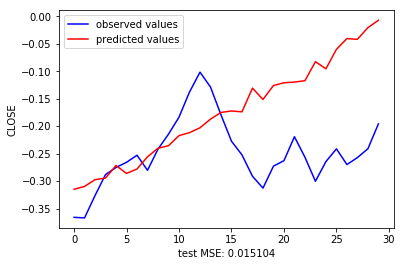

[0.003049743970481117, 0.0014723832883833067, 0.001628014369952913, 0.001368504852823556, 0.001679752862570366, 0.0015351189955737777, 0.0013440171227094475, 0.0016123725858591623, 0.0012167550475309483, 0.001348174451953834, 0.0010782316978308676, 0.001097782474801288, 0.0017721786921815648, 0.0012573931417291287, 0.0011220727315490102, 0.0009804145728894184, 0.0012382498997250602, 0.0009631300180484547, 0.001312649281787963, 0.0011937307872782878, 0.0010691322690849045, 0.005087213510213699, 0.0045350056633302925, 0.004096260677292911, 0.002807922231421962, 0.007068465148397668, 0.005428072923982596, 0.0061382163094727635, 0.004679884688360519, 0.003307598706101443, 0.005819016861162437, 0.004404018082163383, 0.003325285465514938, 0.0026032988921312443, 0.0019905174513728803, 0.0021199531013803576, 0.0018930285052840984, 0.0018775875965614162, 0.002079165838753284, 0.0015504393474465587, 0.002460049028965032, 0.0018820292334520746, 0.0025620251456945752, 0.0016875930200424048, 0.0021

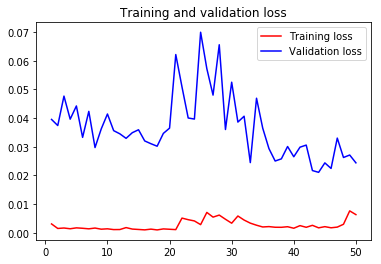

In [17]:
fig_1 = plt.figure(1)
plt.plot(close_values[-30:].T.reshape(30,), color='blue', label='observed values')
plt.plot(predictions, color='red', label='predicted values')

plt.xlabel('test MSE: %f' % test_mse)
plt.ylabel('CLOSE')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

print(loss, val_loss)
fig_2 = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()